In [2]:
from sklearn.linear_model import LassoCV, LinearRegression,RidgeCV,LogisticRegression
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer, scale
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
import matplotlib.pyplot as plt

## Logistic Regression

Best for A or no A: AUC 0.6457323506689945, 65% accuracy
```
model=LogisticRegression(max_iter=10000,penalty="l1",solver="liblinear").fit(X_train,y_train)
```

A without 0.1: AUC 0.60, 80% accuracy (l1, liblinear)

AB or not AB: severe overfitting

Best when dropping 0.1: split at 1, AUC 0.64

Drop 0.5 and below, split 1 or 0 at firesize > 2, AUC 0.67
Drop 0.5 and below, split at firesize > 2, class_weight 0.8 - 0.2, 0.67

drop 1 and below: split at 5

drop 10 and below: split at 50, AUC= 0.648 (only 1000 rows)

Keep all, split at 0.5, class_weight 0.05-0.95, no false negatives, AUC 0.64


AUC 0.66, keep all rows, class weights 0.1 - 0.9, fpr = 87%, fnr = 5%

### Final options

Drop rows smaller than 0.5. Fires > 2 acres = 1, <= 2 acres = 0

class_weight= {0:0.4,1:0.6}

* accuracy 0.624246483590087
* auc 0.671191247974068
* 0.3338735818476499 = 1-recall (capture 66% of big fires)
* 46% false alarm rate (<50%)

class_weight= {0:0.3,1:0.7}

* accuracy 0.5733422638981915
* auc 0.6710284333533152
* 0.1312803889789303 = 1-recall (capture 87% of big fires)
* 50.9% false alarm rate (>50%)


Don't drop rows smaller than 0.5; Fires > 2 acres = 1, <= 2 acres = 0
class_weight= {0:0.1,1:0.9}

* accuracy 0.46
* auc 0.6510284333533152
* 0.21 = 1-recall (capture 79% of big fires)
* 84% false alarm rate (>50%)



In [117]:
a = pd.read_csv("clean_fire_weather_classification_withfiresize2.csv")
a=a.drop(columns="Unnamed: 0")

In [122]:
a.loc[:,"STAT_CAUSE_CODE_10":].sum()

STAT_CAUSE_CODE_10      57
STAT_CAUSE_CODE_11     208
STAT_CAUSE_CODE_12      21
STAT_CAUSE_CODE_13    2873
STAT_CAUSE_CODE_2     4304
STAT_CAUSE_CODE_3     1000
STAT_CAUSE_CODE_4     2109
STAT_CAUSE_CODE_5     1158
STAT_CAUSE_CODE_6      102
STAT_CAUSE_CODE_7     2225
STAT_CAUSE_CODE_8      934
STAT_CAUSE_CODE_9     6855
dtype: int64

In [34]:
a.FIRE_SIZE.describe()

count     30951.000000
mean        119.261355
std        2701.119192
min           0.001000
25%           0.100000
50%           0.100000
75%           1.000000
max      315578.800000
Name: FIRE_SIZE, dtype: float64

In [35]:
a=a[a["FIRE_SIZE"]>=0.5]

In [36]:
a["FIRE_SIZE_CLASS"].value_counts(normalize=True)

B    0.772398
C    0.138941
D    0.036727
E    0.020691
F    0.018208
G    0.013035
Name: FIRE_SIZE_CLASS, dtype: float64

In [37]:
#Define classes
a["BIN_FIRE_SIZE"] = (a["FIRE_SIZE"]>=2)
#a["BIN_FIRE_SIZE"] = (a["FIRE_SIZE_CLASS"].isin(["A","B"]))
a.loc[a["BIN_FIRE_SIZE"] == True,"BIN_FIRE_SIZE"] =1
a.loc[a["BIN_FIRE_SIZE"] == False,"BIN_FIRE_SIZE"] =0
a=a.drop(columns=["FIRE_SIZE_CLASS","FIRE_SIZE"])
a.BIN_FIRE_SIZE = a.BIN_FIRE_SIZE.astype(float)

In [38]:
a["BIN_FIRE_SIZE"].value_counts(normalize=True)

0.0    0.525553
1.0    0.474447
Name: BIN_FIRE_SIZE, dtype: float64

In [17]:
#a.to_csv("splitat2.csv",index=False)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(a.drop(columns=["BIN_FIRE_SIZE"]), a.BIN_FIRE_SIZE, test_size=0.30, random_state=42)

In [69]:
model=LogisticRegression(max_iter=10000,penalty="l1",solver="liblinear",class_weight={0:0.43,1:0.57}).fit(X_train,y_train)

In [70]:
model.score(X_test,y_test) #accuracy

0.5717241379310345

In [71]:
y_pred = model.predict_proba(X_test)[:,1]
cart_auc = roc_auc_score(y_test,y_pred)
cart_auc #AUC

0.6160723531227885

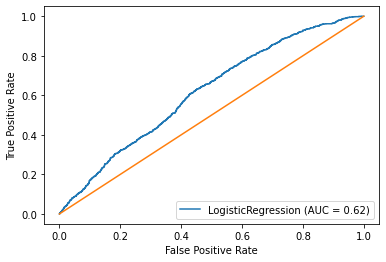

In [72]:
plot_roc_curve(model,X_test,y_test)
plt.plot([0, 1], [0, 1])

In [73]:
tn, fp, fn, tp = confusion_matrix(y_test.values,model.predict(X_test)).ravel()
tn,fp,fn,tp

(567, 966, 276, 1091)

In [74]:
fn/(tp+fn) #think it's big when it's not (rate of thinking small fires are big)

0.20190197512801755

In [75]:
fp/(fp+tn) #think it's small when it's not (rate of missing big fires)

0.6301369863013698

## Data stuff

In [ ]:
a["FIRE_SIZE_CLASS"].value_counts(normalize=True)

In [ ]:
a.groupby("FIRE_SIZE_CLASS").count()

In [ ]:
a["efiresize"].value_counts(normalize=True)

In [ ]:
a["efiresize"] = np.exp(a.FIRE_SIZE)

## Linear Regression

In [100]:
a = pd.read_csv("clean_fire_weather_Kiran.csv")
a

,Unnamed: 0,drybulbtemp,atm_moisture,wind_azimuth,avg_windspeed,fuelmoisture,maxtemp,mintemp,maxhumid,minhumid,...,STAT_CAUSE_CODE_12,STAT_CAUSE_CODE_13,STAT_CAUSE_CODE_2,STAT_CAUSE_CODE_3,STAT_CAUSE_CODE_4,STAT_CAUSE_CODE_5,STAT_CAUSE_CODE_6,STAT_CAUSE_CODE_7,STAT_CAUSE_CODE_8,STAT_CAUSE_CODE_9
0,1,69.0,30.0,162.0,7.0,6.0,70.0,35.0,82.0,28.0,...,0,0,0,0,0,0,0,0,0,0
1,2,57.0,42.0,220.0,1.0,8.0,57.0,30.0,78.0,39.0,...,0,0,0,0,0,0,0,0,0,1
2,3,80.0,22.5,194.0,3.0,5.0,80.5,39.0,75.5,17.0,...,0,0,0,0,0,0,0,0,0,1
3,4,84.6,26.8,261.0,3.4,5.0,85.6,49.2,68.0,17.4,...,0,0,1,0,0,0,0,0,0,0
4,5,87.0,32.6,221.2,2.6,5.0,87.0,54.8,76.8,28.4,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17286,17287,97.0,17.0,305.0,1.0,5.0,97.0,49.0,82.0,14.0,...,0,0,0,0,0,0,0,1,0,0
17287,17288,103.0,20.0,118.0,4.0,5.0,104.0,69.0,47.0,18.0,...,0,0,0,0,0,0,0,0,0,1
17288,17289,103.0,20.0,118.0,4.0,5.0,104.0,69.0,47.0,18.0,...,0,0,0,0,0,0,0,0,0,1
17289,17290,90.0,34.0,216.0,1.0,6.0,92.0,66.0,64.0,30.0,...,0,0,1,0,0,0,0,0,0,0


In [101]:
a=(a[a.FIRE_SIZE > 0.5]).drop(columns=["Unnamed: 0"])

In [102]:
a

,drybulbtemp,atm_moisture,wind_azimuth,avg_windspeed,fuelmoisture,maxtemp,mintemp,maxhumid,minhumid,precip_duration,...,STAT_CAUSE_CODE_12,STAT_CAUSE_CODE_13,STAT_CAUSE_CODE_2,STAT_CAUSE_CODE_3,STAT_CAUSE_CODE_4,STAT_CAUSE_CODE_5,STAT_CAUSE_CODE_6,STAT_CAUSE_CODE_7,STAT_CAUSE_CODE_8,STAT_CAUSE_CODE_9
5,87.000000,32.600000,221.200000,2.600000,5.0,87.000000,54.800000,76.800000,28.400000,0.0,...,0,0,1,0,0,0,0,0,0,0
13,87.800000,18.400000,197.800000,4.400000,4.0,88.600000,50.600000,57.600000,15.600000,0.0,...,0,0,1,0,0,0,0,0,0,0
14,91.000000,22.000000,329.000000,3.000000,3.0,91.000000,51.000000,59.000000,22.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
19,90.000000,26.250000,262.250000,3.000000,6.0,95.500000,65.750000,63.250000,22.250000,0.0,...,0,0,0,0,0,0,0,0,0,1
24,79.333333,25.333333,288.333333,3.333333,5.0,80.000000,44.666667,69.333333,22.333333,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,83.555556,17.555556,177.333333,2.888889,6.0,86.333333,49.111111,76.888889,14.777778,0.0,...,0,0,0,0,0,0,0,0,0,1
17275,90.444444,11.888889,153.222222,2.777778,4.0,93.888889,54.000000,44.333333,8.222222,0.0,...,0,0,0,0,0,0,0,0,0,1
17276,90.444444,11.888889,153.222222,2.777778,4.0,93.888889,54.000000,44.333333,8.222222,0.0,...,0,0,0,0,1,0,0,0,0,0
17282,92.777778,8.333333,247.444444,3.555556,3.0,97.333333,56.777778,39.111111,7.333333,0.0,...,0,0,0,0,0,0,0,0,0,1


In [103]:
X_train, X_test, y_train, y_test = train_test_split(a.drop(columns=["FIRE_SIZE"]), a.FIRE_SIZE, test_size=0.30, random_state=42)

In [104]:
reg = LinearRegression().fit(X_train,y_train)

In [105]:
y_pred=reg.predict(X_test)

In [106]:
1 - (sum((y_pred - y_test)**2)/sum((np.mean(y_train) - y_test)**2))

0.044929753058662536

In [107]:
la = LassoCV(cv=5,alphas=[0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01],max_iter=100000000).fit(X_train,y_train)

In [108]:
la.alpha_

0.001

In [109]:
y_pred=la.predict(X_test)

In [110]:
1 - (sum((y_pred - y_test)**2)/sum((np.mean(y_train) - y_test)**2))

0.0463169999138886

In [111]:
ri = RidgeCV(cv=5,alphas=list(range(30,60))).fit(X_train,y_train)

In [112]:
ri.alpha_

30

In [113]:
y_pred=ri.predict(X_test)

In [114]:
1 - (sum((y_pred - y_test)**2)/sum((np.mean(y_train) - y_test)**2))

0.043337373811436986

In [115]:
X_train.columns[la.coef_==0]

Index(['wetflag_Y', 'FIPS_NAME_y_Butte', 'FIPS_NAME_y_Colusa',
       'FIPS_NAME_y_El Dorado', 'FIPS_NAME_y_Glenn', 'FIPS_NAME_y_Inyo',
       'FIPS_NAME_y_Marin', 'FIPS_NAME_y_Mendocino', 'FIPS_NAME_y_Merced',
       'FIPS_NAME_y_San Benito', 'FIPS_NAME_y_Yolo', 'STAT_CAUSE_CODE_6'],
      dtype='object')

In [116]:
la.coef_

array([-3.19601084e-02, -2.37757678e-02, -5.32042155e-04,  5.63973721e-02,
       -4.82523342e-03,  1.97706318e-02,  1.40763930e-02, -1.11055020e-02,
        4.29850359e-03,  8.55537411e-02, -1.17356667e-04, -2.00244771e-02,
       -1.65324760e-01,  5.21683692e-03,  1.33620596e-05, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  1.21458208e-02,
        0.00000000e+00,  0.00000000e+00,  3.57462635e+00, -3.41988603e-02,
        1.72864474e-01,  2.15769380e-01, -2.25623088e-02, -0.00000000e+00,
        3.09014828e-01,  0.00000000e+00,  0.00000000e+00, -2.56285877e-01,
        7.16613898e-01, -4.33732345e-01, -4.19113065e-01,  5.71998205e-01,
       -1.06875625e-01, -0.00000000e+00,  1.69660945e-01,  1.80428053e-01,
        5.16435347e+00, -4.88787452e-01, -9.04975899e-01,  5.08509705e-01,
       -3.44170757e-01, -1.90337441e-01,  6.79870890e-01,  2.94656194e-01,
       -4.38503363e-01,  0.00000000e+00, -5.06308092e-01,  3.97282245e-01,
       -8.86188114e-01,  